In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from time import time
from tqdm import tqdm
import numpy as np

import xarray as xr
import torchvision

import optax
import jax.numpy as jnp
import jax
import flax.linen as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

## Model

In [15]:
class NeRFReLU(nn.Module):
    n_hidden_layer_neurons: list
    output_shape: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden_layer_neurons[0])(x)
        x = nn.relu(x)
        for i in range(1, len(self.n_hidden_layer_neurons)):
            x = nn.Dense(self.n_hidden_layer_neurons[i])(x)
            x = nn.relu(x)
        x = nn.Dense(self.output_shape)(x)
        return x
    
# define initializers
def first_layer_init(key, shape, dtype=jnp.float32):
    num_input = shape[0]  # reverse order compared to torch
    return jax.random.uniform(key, shape, dtype, minval=-1.0/num_input, maxval=1.0/num_input)

def other_layers_init(key, shape, dtype=jnp.float32):
    num_input = shape[0]  # reverse order compared to torch
    return jax.random.uniform(key, shape, dtype, minval=-np.sqrt(6 / num_input)/30, maxval=np.sqrt(6 / num_input)/30)

class NeRFSine(nn.Module):
    n_hidden_layer_neurons: list
    output_shape: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden_layer_neurons[0], kernel_init=first_layer_init, bias_init=first_layer_init)(x)
        x = jnp.sin(30*x)
        for i in range(1, len(self.n_hidden_layer_neurons)):
            x = nn.Dense(self.n_hidden_layer_neurons[i], kernel_init=other_layers_init, bias_init=other_layers_init)(x)
            x = jnp.sin(30*x)
        x = nn.Dense(self.output_shape, kernel_init=other_layers_init, bias_init=other_layers_init)(x)
        return x
    
def fit(key, model, train_x, train_y, lr, batch_size, iterations):
    train_x = jnp.asarray(train_x)
    train_y = jnp.asarray(train_y)
    
    # initialize params
    params = model.init(key, jnp.ones((1, train_x.shape[1])))

    # loss fun
    def loss_fn(params, x, y, key):
        y_hat = model.apply(params, x, rngs={'dropout': key})
        loss = jnp.mean((y - y_hat)**2)
        return loss
    value_and_grad_fn = jax.value_and_grad(loss_fn)

    optimizer = optax.adam(lr)
    state = optimizer.init(params)

    # lax scan loop
    @jax.jit
    def one_step(params_and_state, key):
        params, state = params_and_state
        if batch_size < train_y.shape[0]:
            batch_idx = jax.random.choice(key, jnp.arange(train_x.shape[0]), shape=(batch_size,), replace=False)
            x = train_x[batch_idx]
            y = train_y[batch_idx]
        else:
            x = train_x
            y = train_y
        value, grads = value_and_grad_fn(params, x, y, key)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
        return (params, state), value

    keys = jax.random.split(key, iterations)
    (params, state), losses = jax.lax.scan(one_step, (params, state), xs=keys)
    return params, losses

def predict(model, params, x):
    return model.apply(params, x)

## Test on image first

In [16]:
# load fashion mnist
fashion_mnist = torchvision.datasets.FashionMNIST('./data', download=True)
img = fashion_mnist.data[0].numpy()
img = img / 255.0

x1, x2 = np.meshgrid(np.linspace(-1, 1, img.shape[0]), np.linspace(0, 1, img.shape[1]))
train_x = np.stack([x1.flatten(), x2.flatten()], axis=1)
train_y = img.reshape(-1, 1)

lr = 1e-4
batch_size = train_y.shape[0]//2
iterations = 9000
n_hidden_layer_neurons = [256]*4

key = jax.random.PRNGKey(1)

init = time()
relu_model = NeRFReLU(n_hidden_layer_neurons=n_hidden_layer_neurons, output_shape=1)
relu_params, relu_losses = fit(key, relu_model, train_x, train_y, lr=lr, batch_size=batch_size, iterations=iterations)
relu_out_img = predict(relu_model, relu_params, train_x).reshape(img.shape)
print(f"relu time: {time() - init:.2f}s")

init = time()
sine_model = NeRFSine(n_hidden_layer_neurons=n_hidden_layer_neurons, output_shape=1)
sine_params, sine_losses = fit(key, sine_model, train_x, train_y, lr=lr, batch_size=batch_size, iterations=iterations)
sine_out_img = predict(sine_model, sine_params, train_x).reshape(img.shape)
print(f"sine time: {time() - init:.2f}s")

relu time: 2.63s
sine time: 3.17s


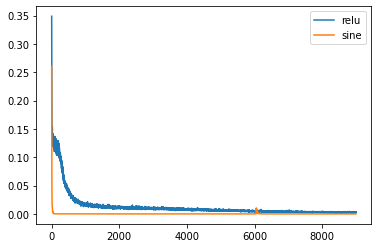

In [17]:
offset = 0
plt.plot(relu_losses[offset:], label='relu')
plt.plot(sine_losses[offset:], label='sine')
plt.legend();

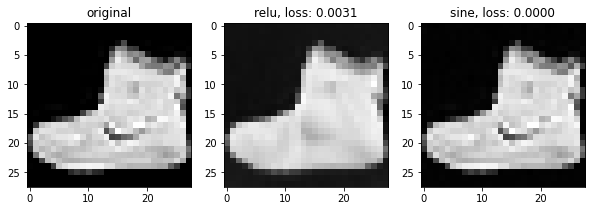

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img, cmap='gray');ax[0].set_title('original')
ax[1].imshow(relu_out_img, cmap='gray');ax[1].set_title(f'relu, loss: {relu_losses[-1]:.4f}')
ax[2].imshow(sine_out_img, cmap='gray');ax[2].set_title(f'sine, loss: {sine_losses[-1]:.4f}');

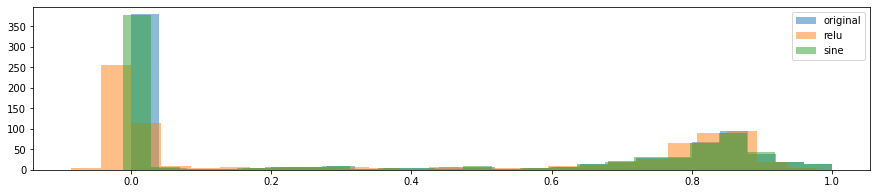

In [19]:
plt.figure(figsize=(15, 3))
plt.hist(img.ravel(), bins=25, alpha=0.5, label='original');
plt.hist(relu_out_img.ravel(), bins=25, alpha=0.5, label='relu');
plt.hist(sine_out_img.ravel(), bins=25, alpha=0.5, label='sine');
plt.legend();

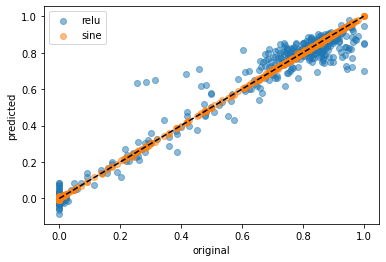

In [20]:
plt.scatter(img.ravel(), relu_out_img.ravel(), alpha=0.5, label='relu');
plt.scatter(img.ravel(), sine_out_img.ravel(), alpha=0.5, label='sine');
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('original')
plt.ylabel('predicted')
plt.legend();

## Improve image resolution

original shape: (136, 204, 3)
scaled shape: (68, 102, 3)


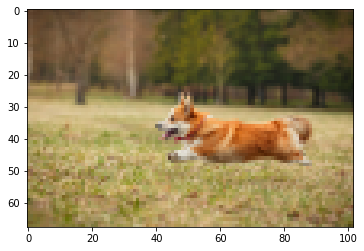

In [92]:
img = plt.imread("../dog.jpg")
img = img / 255.0

# initial scaling
initial_factor = 10
img = nn.avg_pool(img, window_shape=(initial_factor, initial_factor), strides=(initial_factor, initial_factor))

# scale down image by factor of 2
factor = 2
print(f"original shape: {img.shape}")
scaled_img = nn.avg_pool(img, window_shape=(factor, factor), strides=(factor, factor))
print(f"scaled shape: {scaled_img.shape}")

plt.imshow(scaled_img);

In [96]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, scaled_img.shape[0]), np.linspace(-1, 1, scaled_img.shape[1]))
train_x = np.stack([x1.flatten(), x2.flatten()], axis=1)
test_x1, test_x2 = np.meshgrid(np.linspace(-1, 1, img.shape[0]), np.linspace(-1, 1, img.shape[1]))
test_x = np.stack([test_x1.flatten(), test_x2.flatten()], axis=1)

train_y = scaled_img.reshape(-1, 3)

lr = 1e-4
batch_size = train_y.shape[0]
iterations = 9000
n_hidden_layer_neurons = [256]*4

key = jax.random.PRNGKey(1)
sine_model = NeRFSine(n_hidden_layer_neurons=n_hidden_layer_neurons, output_shape=train_y.shape[1])
sine_params, sine_losses = fit(key, sine_model, train_x, train_y, lr=lr, batch_size=batch_size, iterations=iterations)
pred_scaled_img = predict(sine_model, sine_params, train_x).reshape(scaled_img.shape)
pred_img = predict(sine_model, sine_params, test_x).reshape(img.shape)

Array(2.270557e-06, dtype=float32)

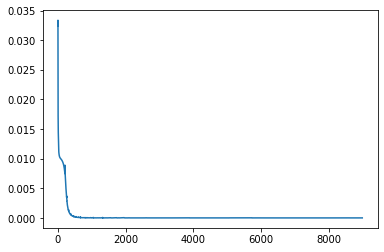

In [97]:
offset = 10
plt.plot(sine_losses[offset:]);
sine_losses[-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(68, 102, 3) (136, 204, 3)


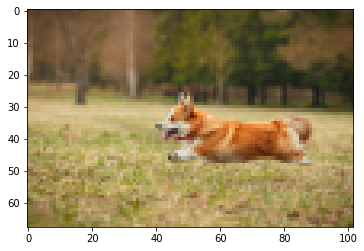

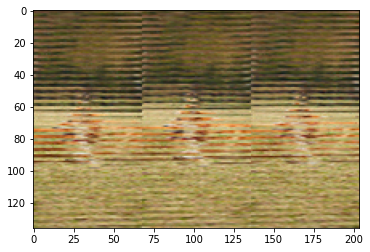

In [98]:
plt.imshow(pred_scaled_img);
plt.figure();
plt.imshow(pred_img);
print(pred_scaled_img.shape, pred_img.shape)

## Load AQ data

In [8]:
data = xr.open_dataset("../data/delhi_cpcb_2022.nc")
df = data.to_dataframe().reset_index().set_index("time")
df = df.loc["2022"].reset_index()

# convert time to hours starting from 2022
df["time"] = (df["time"] - df["time"].min()) / np.timedelta64(1, 'h')

assert df.shape[0] == 365*24*40 == 350400 # 40 stations for 365 days and 24 hours (including missing data)

In [9]:
# count number of entries for each station
station_counts = df.dropna(subset="PM2.5").groupby("station").count()["time"].sort_values(ascending=False) / (365*24)
bad_stations = station_counts[station_counts < 0.82].index.values
df = df[~df["station"].isin(bad_stations)]
df.station.unique().shape

(36,)

In [10]:
# drop missing data
size_before = df.shape[0]
train_data = df[["latitude", "longitude", "time", "PM2.5"]].dropna(how="any", axis=0)
# train_data["PM2.5"] = train_data["PM2.5"].apply(lambda x: np.nan if x > 300 else x)
train_data = train_data.dropna(how="any", axis=0)
size_after = train_data.shape[0]
print(f"dropped {size_before - size_after} rows with missing data. Percentage: {(size_before - size_after)/size_before*100:.2f}%")

dropped 20333 rows with missing data. Percentage: 6.45%


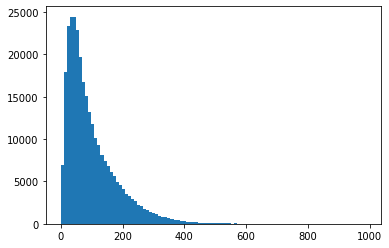

In [11]:
plt.hist(train_data["PM2.5"], bins=100);

## Fit models

In [12]:
lr = 1e-4
batch_size = train_data.shape[0]
iterations = 9000
n_hidden_layer_neurons = [256]*4
log_transform = False

train_x = train_data[["latitude", "longitude", "time"]].values
print(train_x.shape)
scaler_x = MinMaxScaler((0, 1))
train_x = scaler_x.fit_transform(train_x)
# transform time
train_x[:, 2] = 20*train_x[:, 2] - 10
print(train_x.min(axis=0), train_x.max(axis=0))

scaler_y = StandardScaler()
train_y = train_data[["PM2.5"]].values
if log_transform:
    train_y = np.log(train_y)
train_y = scaler_y.fit_transform(train_y)

key = jax.random.PRNGKey(0)

init = time()
relu_model = NeRFReLU(n_hidden_layer_neurons=n_hidden_layer_neurons, output_shape=1)
relu_params, relu_losses = fit(key, relu_model, train_x, train_y, lr=lr, batch_size=batch_size, iterations=iterations)
relu_out = predict(relu_model, relu_params, train_x)
relu_out_ = scaler_y.inverse_transform(relu_out)
if log_transform:
    relu_out_ = np.exp(relu_out_)
print(f"relu time: {time() - init:.2f}s")

init = time()
sine_model = NeRFSine(n_hidden_layer_neurons=n_hidden_layer_neurons, output_shape=1)
sine_params, sine_losses = fit(key, sine_model, train_x, train_y, lr=lr, batch_size=batch_size, iterations=iterations)
sine_out = predict(sine_model, sine_params, train_x)
sine_out_ = scaler_y.inverse_transform(sine_out)
if log_transform:
    sine_out_ = np.exp(sine_out_)
print(f"sine time: {time() - init:.2f}s")

train_y_ = scaler_y.inverse_transform(train_y)
if log_transform:
    train_y_ = np.exp(train_y_)

(295027, 3)
[  0.   0. -10.] [ 1.  1. 10.]
relu time: 83.14s
sine time: 90.39s


relu final rmse: 59.01381423703055
sine final rmse: 7.159897984845024


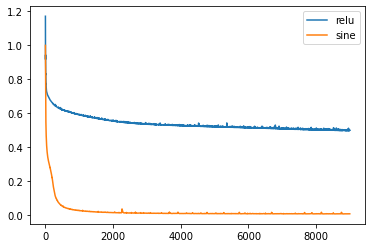

In [13]:
offset = 0
plt.plot(relu_losses[offset:], label='relu')
plt.plot(sine_losses[offset:], label='sine')
plt.legend();

print(f"relu final rmse: {np.sqrt(np.mean((relu_out_ - train_y_)**2))}")
print(f"sine final rmse: {np.sqrt(np.mean((sine_out_ - train_y_)**2))}")

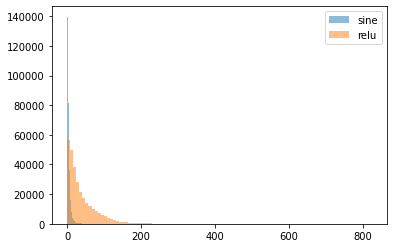

In [14]:
plt.hist(np.abs((sine_out_ - train_y_)), bins=100, label="sine", alpha=0.5);
plt.hist(np.abs((relu_out_ - train_y_)), bins=100, label="relu", alpha=0.5);
plt.legend();

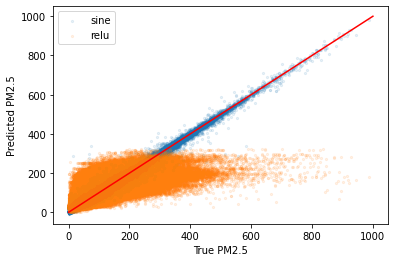

In [15]:
plt.scatter(train_y_, sine_out_, alpha=0.1, s=5, label="sine");
plt.scatter(train_y_, relu_out_, alpha=0.1, s=5, label="relu");
plt.plot([0, 1000], [0, 1000], color="red")
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5");
plt.legend();
# plt.xlim(0, 1000)
# plt.ylim(0, 1000);
# plt.xlim(0, 1)
# plt.ylim(0, 1);

## Audio

In [25]:
# load wav file
import torchaudio
# audio = torchaudio.load("../data_gt_bach.wav")
audio = torchaudio.load("../data_gt_bach.wav")

# from 6 seconds use last 2 seconds
audio_cut = audio[0]#[:, -2*audio[1]:]
audio_cut, audio_cut.shape[1]/audio[1]
audio_cut = audio_cut.numpy().reshape(-1, 1)
audio_x = np.linspace(-100, 100, audio_cut.shape[0]).reshape(-1, 1)

# scaler_y = MinMaxScaler((0, 1))
# audio_cut = scaler_y.fit_transform(audio_cut)
audio_x.shape, audio_cut.shape, audio_x.min(), audio_x.max(), audio_cut.min(), audio_cut.max()

((308207, 1), (308207, 1), -100.0, 100.0, -0.868308, 1.0)

In [26]:
lr = 1e-4
batch_size = audio_cut.size
iterations = 9000
n_hidden_layer_neurons = [256]*4

init = time()
key = jax.random.PRNGKey(0)
relu_model = NeRFReLU(n_hidden_layer_neurons=n_hidden_layer_neurons, output_shape=1)
relu_params, relu_losses = fit(key, relu_model, audio_x, audio_cut, lr=lr, batch_size=batch_size, iterations=iterations)
relu_out = predict(relu_model, relu_params, audio_x)
# sine_out_ = scaler_y.inverse_transform(sine_out)
print(f"relu time: {time() - init:.2f}s")

init = time()
key = jax.random.PRNGKey(0)
sine_model = NeRFSine(n_hidden_layer_neurons=n_hidden_layer_neurons, output_shape=1)
sine_params, sine_losses = fit(key, sine_model, audio_x, audio_cut, lr=lr, batch_size=batch_size, iterations=iterations)
sine_out = predict(sine_model, sine_params, audio_x)
# sine_out_ = scaler_y.inverse_transform(sine_out)
print(f"sine time: {time() - init:.2f}s")

relu time: 75.49s
sine time: 86.58s


In [27]:
# p = sine_params['params']["Dense_0"]
# p
# p.min(), p.max()
# sine_out.min(), sine_out.max(), sine_out.mean()
# plt.hist(np.array(sine_out).ravel(), bins=100);

(Array(2.6557678e-05, dtype=float32), Array(0.02419589, dtype=float32))

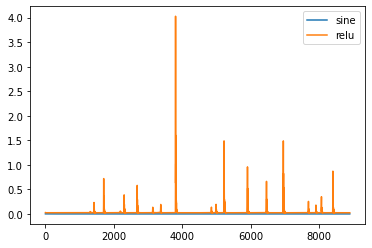

In [28]:
offset = 100
plt.plot(sine_losses[offset:], label='sine');
plt.plot(relu_losses[offset:], label='relu');
plt.legend();
sine_losses[-1], relu_losses[-1]

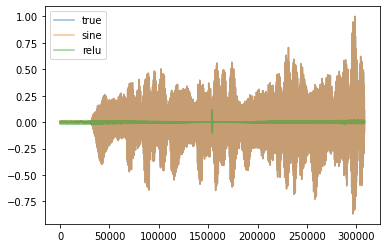

In [29]:
plt.plot(audio_cut, alpha=0.5, label="true");
plt.plot(sine_out, alpha=0.5, label="sine");
plt.plot(relu_out, alpha=0.5, label="relu");
plt.legend();

In [30]:
pred_y = predict(sine_model, sine_params, audio_x)

from IPython.display import Audio
Audio(pred_y.reshape(-1), rate=audio[1])

In [31]:
pred_y = predict(relu_model, relu_params, audio_x)

from IPython.display import Audio
Audio(pred_y.reshape(-1), rate=audio[1])

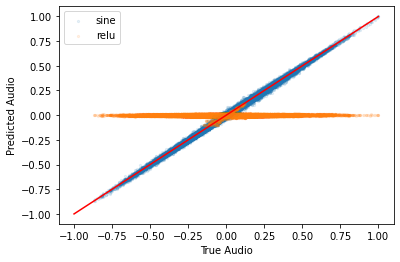

In [32]:
plt.scatter(audio_cut, sine_out, alpha=0.1, s=5, label="sine");
plt.scatter(audio_cut, relu_out, alpha=0.1, s=5, label="relu");
plt.plot([-1, 1], [-1, 1], color="red")
plt.xlabel("True Audio")
plt.ylabel("Predicted Audio");
plt.legend();